# JUMP2DIGITAL

Nil Biescas Rue

In [1]:
import pandas as pd 

c:\Users\34644\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\34644\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\34644\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
csv_lloguers = r'C:\Users\34644\Desktop\JUMP2DIGITAL HACKHATHO\2017_lloguer_preu_trim.csv'
lloguers = pd.read_csv(csv_lloguers)

El conjunt de dades conté informació sobre el lloguer mitjà mensual ("Lloguer_mitja") en diversos districtes ("Nom_Districte") i barris ("Nom_Barri") per a l'any 2017, desglossat per trimestres ("Trimestre")

Per coneixer millor les dades utilizem .info() que ens diu per cada columna el tipo de dada i si la columna conte algun valor buit. Ens donem conte que a la columna Preu hi han algunes files que no en tenen. 

In [3]:
lloguers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Any             584 non-null    int64  
 1   Trimestre       584 non-null    int64  
 2   Codi_Districte  584 non-null    int64  
 3   Nom_Districte   584 non-null    object 
 4   Codi_Barri      584 non-null    int64  
 5   Nom_Barri       584 non-null    object 
 6   Lloguer_mitja   584 non-null    object 
 7   Preu            546 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 36.6+ KB


Per saber una mica mes de les dades, miro el numero de elements diferents que hi ha a cada columna i observo que al lloguer mitja tenim 2 valors diferents.

In [4]:
lloguers.apply(lambda x: x.unique().__len__())

Any                 1
Trimestre           4
Codi_Districte     10
Nom_Districte      10
Codi_Barri         73
Nom_Barri          73
Lloguer_mitja       2
Preu              505
dtype: int64

En la columna del lloguer tenim informacio del lloguer mitjà mensual i per superficie.


In [5]:
lloguers['Lloguer_mitja'].unique()

array(['Lloguer mitjà mensual (Euros/mes)',
       'Lloguer mitjà per superfície (Euros/m2 mes)'], dtype=object)

Per exemple pel Raval, tenim la informacio del lloguer mitja mensual i per superficie per trimestre.


In [6]:
lloguers[lloguers['Nom_Barri'] == 'el Clot'][['Trimestre', 'Nom_Barri', 'Lloguer_mitja', 'Preu']]

,Trimestre,Nom_Barri,Lloguer_mitja,Preu
64,1,el Clot,Lloguer mitjà mensual (Euros/mes),774.97
137,2,el Clot,Lloguer mitjà mensual (Euros/mes),740.91
210,3,el Clot,Lloguer mitjà mensual (Euros/mes),775.27
283,4,el Clot,Lloguer mitjà mensual (Euros/mes),777.21
356,1,el Clot,Lloguer mitjà per superfície (Euros/m2 mes),12.26
429,2,el Clot,Lloguer mitjà per superfície (Euros/m2 mes),12.28
502,3,el Clot,Lloguer mitjà per superfície (Euros/m2 mes),12.72
575,4,el Clot,Lloguer mitjà per superfície (Euros/m2 mes),12.47


Saben aixo dividirem les dades en base al lloguer mitja mensual i el preu per metre quadrat

In [7]:
lloguer_mensual = lloguers[lloguers['Lloguer_mitja'] == 'Lloguer mitjà mensual (Euros/mes)'].reset_index()
lloguer_m2      = lloguers[lloguers['Lloguer_mitja'] != 'Lloguer mitjà mensual (Euros/mes)'].reset_index()
# Mateix numero de files
print(lloguer_mensual.shape)
print(lloguer_m2.shape)

(292, 9)
(292, 9)


Si ens fixem el barris que no tenen el preu del lloguer mensual tampoc tenen el preu del metre quadrat.


In [8]:
#Gracies a isna() podem saber quines files tenen valors nuls. Treim aquestes files tant de lloguer_mensual com de lloguer_m2
nan_index_m2 = lloguer_m2[lloguer_m2['Preu'].isna()].index
nan_index_lloguer = lloguer_mensual[lloguer_mensual['Preu'].isna()].index
# Si els indexs son iguals, es que es tracta de les mateixes files i per tant del mateix barri
# all() retorna True si tots els elements del iterable son True volen dir que son iguals
all(nan_index_m2 == nan_index_lloguer)

True

In [9]:
print("Valors nuls lloguer mensual -> {} \tValors nuls lloguer m2 -> {}"
      .format(lloguer_mensual.isna().sum().sum(), lloguer_m2.isna().sum().sum()))

Valors nuls lloguer mensual -> 19 	Valors nuls lloguer m2 -> 19


Per tal de tractar amb aquestes files que no tenen preu, tenim vàries opcions:
- Esborrar-les i perdre la informació.
- Basant-nos en el trimestre, agafar els preus dels barris que estan al mateix districte i fer-ne la mitjana.

Optem per la segona opció, ja que la primera comporta el risc de perdre informació potencial de les altres columnes d'aquella fila.

In [10]:
def actualiza_preus(df):
    def get_mean_price(df, trimestre, districte):
        # Agroupem per trimestre i per districte i obtenim la mitjana del preu per cada districte en cada trimestre
        return df.groupby(['Trimestre', 'Nom_Districte'])['Preu'].mean().loc[trimestre, districte]

    # Obtenim els indexs de les files que no tenen informacio del preu
    Trimestre = df[df['Preu'].isna()]['Trimestre'].values
    districte = df[df['Preu'].isna()]['Nom_Districte'].values

    # Obtenim els nous preus
    nous_preus = []
    for trime, distr in zip(Trimestre, districte):
        # Iterem per cada fila que no te informacio del preu i trobem el preu mitja per aquell districte i trimestre
        nous_preus.append(get_mean_price(df, trime, distr))
    return nous_preus

# Actualitzem els preus de les files que no tenen informacio a la columna Preu
lloguer_mensual.loc[lloguer_mensual['Preu'].isna(), 'Preu'] = actualiza_preus(lloguer_mensual)
lloguer_m2.loc[lloguer_m2['Preu'].isna(), 'Preu'] = actualiza_preus(lloguer_m2)

In [11]:
# Comprovem que ja no tenim valors nuls
print("Valors nuls lloguer mensual -> {} \tValors nuls lloguer m2 -> {}"
      .format(lloguer_mensual.isna().sum().sum(), lloguer_m2.isna().sum().sum()))

Valors nuls lloguer mensual -> 0 	Valors nuls lloguer m2 -> 0


Un cop tenim les dades actualitzades. Afegim el lloguer per m2 al dataframe del lloguer mensual, per tenir la informacio en un mateix dataframe. I eliminem o renobrem columnes o ve ja no ens faran falta o ja existeixen pero amb un altre nom.

Eliminen la columna del trimestre ja que volem treballar amb un unic valor del preu del lloguer tant per m2 com el mensual i no amb quatre (4 trimestres) per cada metrica.

In [12]:
# Afegim el lloguer de m2 al dataframe del lloguer mensual
lloguer_mensual['Lloguer_mitja_m2'] = lloguer_m2['Preu']
# La columna de preu al dataframe del lloguer mensual correspont al lloguer mitjà mensual.
# És per això que li cambiem el seu nom
new = lloguer_mensual.rename({'Preu': 'Lloguer_mitja_mensual'}, axis = 1)
# Eliminem les columnes que no ens interessen perquè ja tenim la informació en altres columnes
llogues_bcn = new.drop(['index', 'Lloguer_mitja'], axis =1)
# Eliminem també la columna del Trimestre ja que més endavant farem la mitjana anual per trimestre
llogues_bcn_mitja_any = llogues_bcn.drop(['Trimestre'], axis = 1)

Ara disposem d'un dataframe que conté la informació del lloguer mitjà mensual i per superfície de cada barri. En la següent cel·la, observem que encara conservem informació de cada barri desglossada per trimestre, raó per la qual cada barri es presenta quatre vegades.  El nostre següent pas serà transformar aquestes dades per calcular la mitjana anual del lloguer i del preu per metre quadrat per cada barri.

In [13]:
llogues_bcn_mitja_any[llogues_bcn_mitja_any['Nom_Barri'] == 'el Raval']


,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja_mensual,Lloguer_mitja_m2
0,2017,1,Ciutat Vella,1,el Raval,734.99,13.50
73,2017,1,Ciutat Vella,1,el Raval,714.29,13.69
146,2017,1,Ciutat Vella,1,el Raval,764.85,13.97
219,2017,1,Ciutat Vella,1,el Raval,776.73,14.42


Per a fer-ho utilizem la funcio groupby de pandas que ens ajuda a agrupar dades que comparteix informacio. Agrupem totes els barris i despres fem la mitja, obtenint aixi la mitja anual de cada barri tant del lloguer mensual com del lloguer per m2.

In [14]:
llogues_bcn_mitja_any['Lloguer_mitja_mensual'] = llogues_bcn_mitja_any.groupby('Nom_Barri')['Lloguer_mitja_mensual'].transform('mean')
llogues_bcn_mitja_any['Lloguer_mitja_m2'] = llogues_bcn_mitja_any.groupby('Nom_Barri')['Lloguer_mitja_m2'].transform('mean')
# Borrem els duplicats perquè tenim informaciò repetida
llogues_bcn_mitja_any.drop_duplicates(subset=['Nom_Barri'], inplace=True)


Depuracio completada

In [15]:
llogues_bcn_mitja_any

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja_mensual,Lloguer_mitja_m2
0,2017,1,Ciutat Vella,1,el Raval,747.7150,13.8950
1,2017,1,Ciutat Vella,2,el Barri Gòtic,973.7675,14.1900
2,2017,1,Ciutat Vella,3,la Barceloneta,746.3100,19.8450
3,2017,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",916.8375,15.7050
4,2017,2,Eixample,5,el Fort Pienc,900.0975,13.0850
...,...,...,...,...,...,...,...
68,2017,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,1109.9775,16.0575
69,2017,10,Sant Martí,70,el Besòs i el Maresme,610.4900,9.9675
70,2017,10,Sant Martí,71,Provençals del Poblenou,934.6925,12.9825
71,2017,10,Sant Martí,72,Sant Martí de Provençals,764.8600,10.8925


## Visualizacions del lloguers

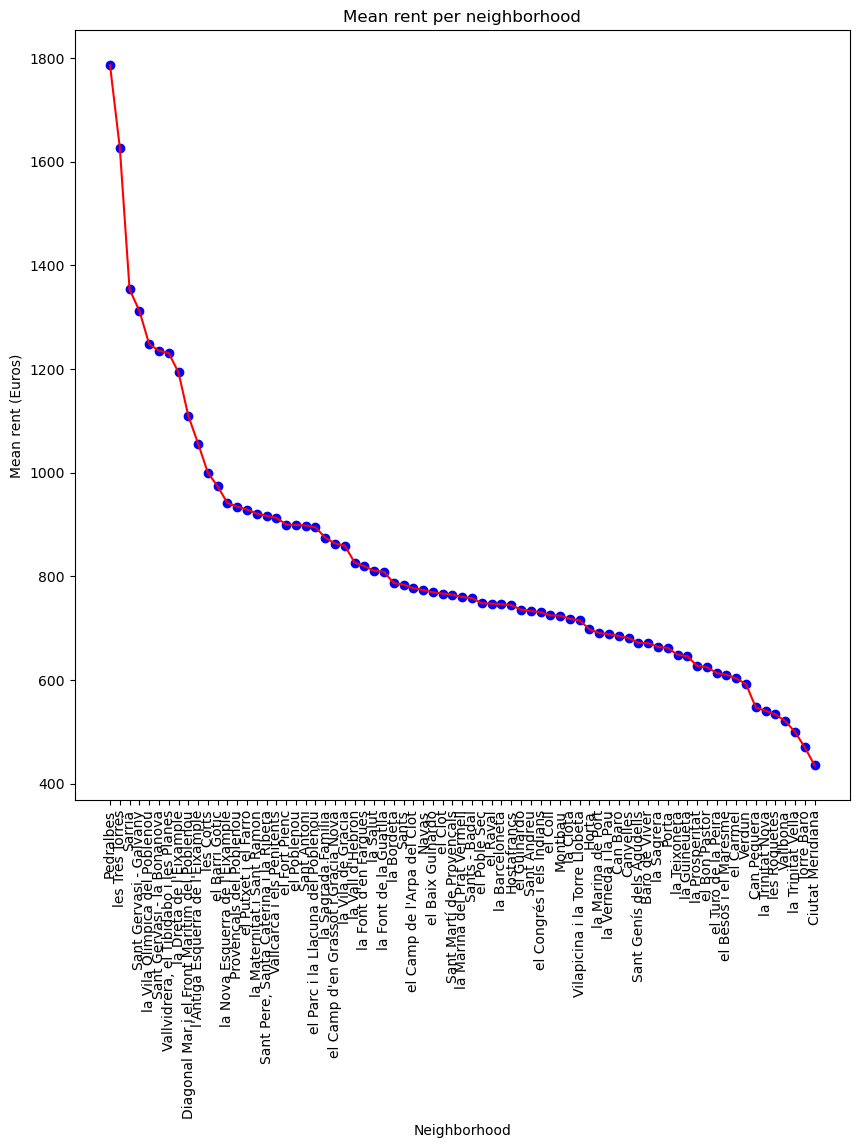

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Arodonir els valors de lloguer mensual i per superficie
llogues_bcn_mitja_any['Lloguer_mitja_mensual'] = llogues_bcn_mitja_any['Lloguer_mitja_mensual'].round(2)
llogues_bcn_mitja_any['Lloguer_mitja_m2'] = llogues_bcn_mitja_any['Lloguer_mitja_m2'].round(2)

# Ordenem els valors de mes gran a mes petit
llogues_bcn_mitja_any.sort_values(by=['Lloguer_mitja_mensual'], inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))

# Dibuixa els punts
ax.scatter(llogues_bcn_mitja_any['Nom_Barri'], llogues_bcn_mitja_any['Lloguer_mitja_mensual'], color='blue')

x = np.arange(len(llogues_bcn_mitja_any))
y = llogues_bcn_mitja_any['Lloguer_mitja_mensual']
ax.plot(x, y, color='red')

# Titols dels eixos
ax.set_title('Mean rent per neighborhood')
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Mean rent (Euros)')

plt.xticks(rotation=90)

plt.show()


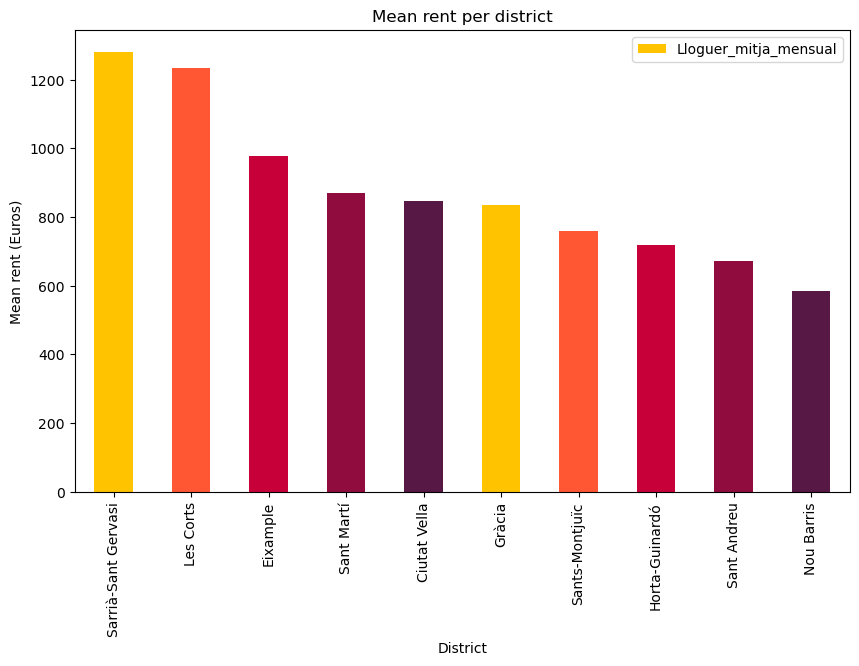

In [17]:
# Agrupem per districte i calculem la mitjana del lloguer per districte
mean_rent_by_district = llogues_bcn_mitja_any.groupby('Nom_Districte')['Lloguer_mitja_mensual'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))

ax = mean_rent_by_district.plot(kind='bar', color=['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845'])
ax.legend()

ax.set_title('Mean rent per district')
ax.set_xlabel('District')
ax.set_ylabel('Mean rent (Euros)')

plt.show()

# SOROLL BCN

El conjunt de dades proporcionat conté informació detallada sobre l'exposició al soroll i els preus de lloguer en diferents barris de Barcelona. Inclou identificadors de districte i barri, noms, una columna de concepte que classifica els tipus de soroll segons la font i el moment del dia, rangs de soroll en decibels, i dades de lloguer tant mensuals com per metre quadrat. Aquesta informació pot ser utilitzada per investigadors o urbanistes per entendre millor la dinàmica urbana de la ciutat.

In [18]:
dataset_sorroll = r'C:\Users\34644\Desktop\JUMP2DIGITAL HACKHATHO\2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv'
sorroll = pd.read_csv(dataset_sorroll)

In [19]:
sorroll

,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73%
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98%
2,1,Ciutat Vella,1,el Raval,TOTAL_D,45-50 dB,7.38%
3,1,Ciutat Vella,1,el Raval,TOTAL_D,50-55 dB,11.97%
4,1,Ciutat Vella,1,el Raval,TOTAL_D,55-60 dB,19.85%
...,...,...,...,...,...,...,...
18975,10,Sant Martí,73,la Verneda i la Pau,PARCS_D,60-65 dB,0.00%
18976,10,Sant Martí,73,la Verneda i la Pau,PARCS_D,65-70 dB,0.00%
18977,10,Sant Martí,73,la Verneda i la Pau,PARCS_D,70-75 dB,0.00%
18978,10,Sant Martí,73,la Verneda i la Pau,PARCS_D,75-80 dB,0.00%


# Processament de les dades

Comprobem si el dataset conte algun valor Nul

In [20]:
print("Numero de nuls al dataset -> {}".format(sorroll.isna().sum().sum()))

Numero de nuls al dataset -> 0


Convertim la columna de string a floats.

In [21]:
# Pasant els percentatges de string a floats
sorroll['Valor'] = sorroll['Valor'].str.replace('%', '').astype(float)

Afegim dues columnes al dataset del soroll: "Lloguer_mitja_mensual" i "Lloguer_mitja_m2". Aquestes columnes contenen la informació del lloguer mitjà mensual i per superfície per barris. La informació es repetirà perquè els barris apareixen més d'una vegada. Però així ens assegurem de tenir tota la informació en un mateix dataset.

In [22]:
# Actualizem els indixes per poder fer el merge
llogues_bcn_mitja_any['Lloguer_mitja_mensual'].index = llogues_bcn_mitja_any['Nom_Barri']
llogues_bcn_mitja_any['Lloguer_mitja_m2'].index = llogues_bcn_mitja_any['Nom_Barri']

# Gracies al indexes a cada barri del dataframe sorroll li correspon un valor de lloguer mitja mensual i per superficie
sorroll['Lloguer_mitja_mensual'] = sorroll['Nom_Barri'].map(llogues_bcn_mitja_any['Lloguer_mitja_mensual'])
sorroll['Lloguer_mitja_m2'] = sorroll['Nom_Barri'].map(llogues_bcn_mitja_any['Lloguer_mitja_m2'])

In [23]:
sorroll.head(1) # Fixem-nos que ara tenim la informacio del lloguer mitja mensual i per superficie

,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor,Lloguer_mitja_mensual,Lloguer_mitja_m2
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73,747.72,13.9


A continuació, generem dos conjunts de dades: un destinat a la creació de gràfics i l'altre per a la reducció de dimensions, aquest últim inclou les columnes categòriques ja convertides en numèriques.

In [24]:
Rang_sorroll = sorroll['Rang_soroll'].unique()
Concepte     = sorroll['Concepte'].unique()

# Creem un diccionari per poder convertir els valors de la columna Rang_soroll i Concepte a numeros
Rang_soroll2numb = dict(zip(Rang_sorroll, range(len(Rang_sorroll))))
concepte2numb = dict(zip(Concepte, range(len(Concepte))))

# Informacio categorica a numerica
sorroll_numeric = (sorroll
           .assign(Concepte=sorroll['Concepte'].map(concepte2numb))
           .assign(Rang_soroll=sorroll['Rang_soroll'].map(Rang_soroll2numb))
           .drop(['Nom_Barri', 'Nom_Districte'], axis=1))

In [25]:
sorroll_numeric.head(1) # Informacio categorica a numerica

,Codi_Districte,Codi_Barri,Concepte,Rang_soroll,Valor,Lloguer_mitja_mensual,Lloguer_mitja_m2
0,1,1,0,0,7.73,747.72,13.9


In [26]:
sorroll.head(1)

,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor,Lloguer_mitja_mensual,Lloguer_mitja_m2
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73,747.72,13.9


# Visualicacions

Estudi de les correlacions entre les fonts de soroll i el preu del lloguer. Agrupem les dades per 'Font de soroll' i 'Rang de soroll'.

In [27]:
# Agrupacio per concepte i rang de soroll. Correlacio entre el valor i el lloguer mitja mensual i per superficie
corr_matrix = sorroll.groupby(['Concepte', 'Rang_soroll'])[['Valor', 'Lloguer_mitja_mensual', 'Lloguer_mitja_m2']].corr()

# Eliminem les correlacions de la diagonal principal
corr_matrix.replace(1, 0, inplace=True)
corr_matrix

Valor  Lloguer_mitja_mensual  \
Concepte   Rang_soroll                                                          
FFCC_D     40-45 dB    Valor                  0.000000              -0.133088   
                       Lloguer_mitja_mensual -0.133088               0.000000   
                       Lloguer_mitja_m2      -0.210098               0.773251   
           45-50 dB    Valor                  0.000000              -0.148816   
                       Lloguer_mitja_mensual -0.148816               0.000000   
...                                                ...                    ...   
VIANANTS_E <40 dB      Lloguer_mitja_mensual -0.003623               0.000000   
                       Lloguer_mitja_m2      -0.239299               0.773251   
           >=80 dB     Valor                       NaN                    NaN   
                       Lloguer_mitja_mensual       NaN               0.000000   
                       Lloguer_mitja_m2            NaN               0.773251   

                                              Lloguer_mitja_m2  
Concepte   Rang_soroll                                          
FFCC_D     40-45 dB    Valor                         -0.210098  
                       Lloguer_mitja_mensual          0.773251  
                       Lloguer_mitja_m2               0.000000  
           45-50 dB    Valor                         -0.252846  
                       Lloguer_mitja_mensual          0.773251  
...                                                        ...  
VIANANTS_E <40 dB      Lloguer_mitja_mensual          0.773251  
                       Lloguer_mitja_m2               0.000000  
           >=80 dB     Valor                               NaN  
                       Lloguer_mitja_mensual          0.773251  
                       Lloguer_mitja_m2               0.000000  

[780 rows x 3 columns]

El resultat anterior representa la correlació existent entre els nivells de soroll en diferents rangs de decibels, produïts per una font de soroll, i el preu del lloguer, tant el mensual com per metre quadrat. A continuació, ordenem de major a menor les files segons la major correlació.

In [28]:
corr_matrix.sort_values(by=['Valor'], ascending=False, key=lambda x: x.abs()).head(5)

,,,Valor,Lloguer_mitja_mensual,Lloguer_mitja_m2
Concepte,Rang_soroll,,,,
OCI_N,40-45 dB,Lloguer_mitja_m2,0.395422,0.773251,0.0
FFCC_DEN,60-65 dB,Lloguer_mitja_m2,-0.391096,0.773251,0.0
FFCC_D,60-65 dB,Lloguer_mitja_m2,-0.376221,0.773251,0.0
OCI_N,45-50 dB,Lloguer_mitja_m2,0.369038,0.773251,0.0
FFCC_E,60-65 dB,Lloguer_mitja_m2,-0.367863,0.773251,0.0


De la taula anterior podem deduir que quan els nivells de soroll són superiors a 60 dB, la correlació del lloguer mitjà per metre quadrat és negativa, volent dir que quan el rang de soroll augmenta, el lloguer mitjà per metre quadrat disminueix. En canvi, si el rang de soroll està entre 40-45 dB, la relació és positiva.

In [29]:
def concepte_soroll_barri():
    groupby = sorroll.groupby(['Nom_Barri', 'Rang_soroll'])
    # Creació d'un diccionari per emmagatzemar els resultats, amb els barris com a claus
    barris = {barri: {} for barri in sorroll['Nom_Barri'].unique()}
    for key, df in groupby:
        # Trobar l'índex on el valor és el màxim dins del dataframe agrupat
        i = df.index[np.where(df['Valor'].values == df['Valor'].max())]
        barris[key[0]][key[1]] = sorroll.iloc[i, :]['Concepte'].values

    return barris

indices = concepte_soroll_barri()


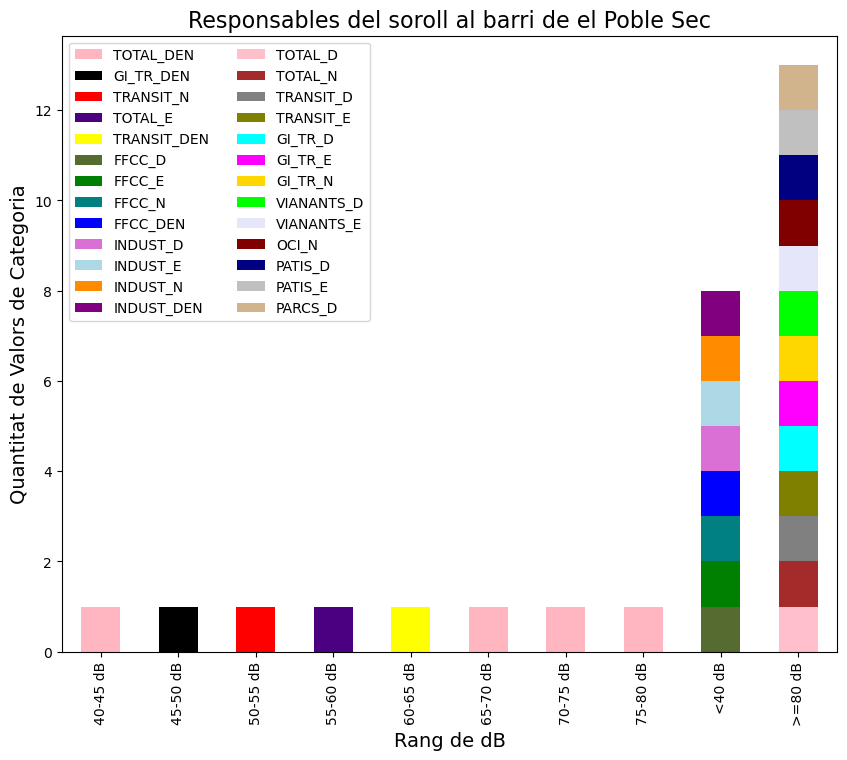

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

# Seleccionem un barri específic del conjunt de dades 'sorroll'
barri_idx = 10 # Cambia el valor per seleccionar un barri diferent
barri = sorroll['Nom_Barri'].unique()[barri_idx]
# Obtenim les dades corresponents al barri seleccionat
data = indices[barri]

# Creem un nou dataframe buit
df = pd.DataFrame()

for key, values in data.items():
    for value in values:
        if value in df:
            df.at[key, value] = df.at[key, value] + 1 if key in df.index else 1
        # Si el concepte de soroll no existeix, l'afegim al dataframe
        else:
            df.at[key, value] = 1

df.fillna(0, inplace=True)

# Definim una llista de colors per als diferents conceptes de soroll
colors = [
    'lightpink', 'black', 'red', 'indigo', 'yellow', 'darkolivegreen', 
    'green', 'teal', 'blue', 'orchid', 'lightblue', 'darkorange', 
    'purple', 'pink', 'brown', 'grey', 'olive', 'cyan', 'magenta', 
    'gold', 'lime', 'lavender', 'maroon', 'navy', 'silver', 'tan'
]

fig, ax = plt.subplots(figsize=(10, 8))
df.plot(kind='bar', stacked=True, ax=ax, color=colors)

ax.set_title('Responsables del soroll al barri de {}'.format(barri), fontsize=16)
ax.set_xlabel('Rang de dB', fontsize=14)
ax.set_ylabel('Quantitat de Valors de Categoria', fontsize=14)

ax.legend(loc='upper left', ncol=2)

# Mostrem el gràfic
plt.show()


De la gràfica següent observem els diferents responsables del soroll al barri del Poble Sec per cada rang. Els colors es repeteixen perquè no s'ha trobat la combinació per a que cada font de soroll tingui un color únic.

# Principal component analysis

<BarContainer object of 2 artists>

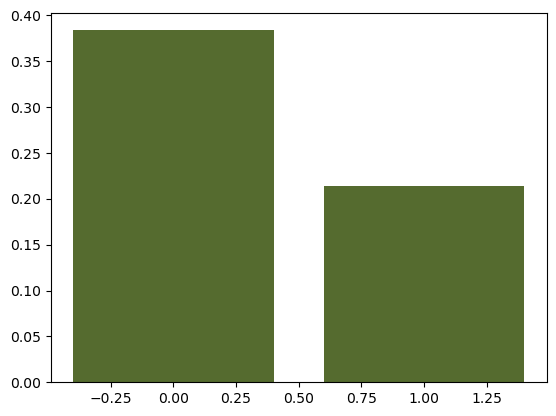

In [31]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandaritzem les dades per tenir una mitjana d'aproximadament 0 i una variança de 1
X_std = StandardScaler().fit_transform(sorroll_numeric)

# Creem una instància de PCA: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)

# Dibuixem les variances explicades
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='darkolivegreen')
